Importing libraries

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 18.0 MB/s eta 0:00:00


In [2]:
import os
import time
import datetime
# from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
!matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

/bin/bash: matplotlib: command not found


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Loading dataset

In [5]:
# load into a data frame
df = pd.read_csv ('/content/drive/MyDrive/train_data_chatbot (1).csv')  
# print(df)

In [6]:
df.head()

,short_question,short_answer,tags,label
0,can an antibiotic through an iv give you a ras...,yes it can even after you have finished the pr...,['rash' 'antibiotic'],1.0
1,can you test positive from having the hep b va...,test positive for what if you had a hep b vacc...,['hepatitis b'],1.0
2,what are the dietary restrictions for celiac d...,omitting gluten from the diet is the key to co...,['celiac disease'],1.0
3,can i transmit genital warts seventeen years a...,yes you could still be pregnant even with the ...,['wart'],-1.0
4,is all vitamin d the same,most helpful answer hi depending on what time ...,['vitamin d'],-1.0


Cleaning dataset

In [7]:
df['short_answer']

0        yes it can even after you have finished the pr...
1        test positive for what if you had a hep b vacc...
2        omitting gluten from the diet is the key to co...
3        yes you could still be pregnant even with the ...
4        most helpful answer hi depending on what time ...
                               ...                        
47598    have you tried some self help books or interne...
47599    in general it is best to discuss with your the...
47600                                                 5050
47601    hi if it is painless and if there are no palpa...
47602    angiotensin ii receptor blockers arbs is a gro...
Name: short_answer, Length: 47603, dtype: object

In [8]:

df_answer = df[df['label'] == 1]['short_answer']


In [9]:
bios = df_answer[:20000] #just use the main bio text in this example
bios

0        yes it can even after you have finished the pr...
1        test positive for what if you had a hep b vacc...
2        omitting gluten from the diet is the key to co...
8        you can always catch an illness from a child b...
10       hi one of ours did that she is now 47 and a mu...
                               ...                        
39926    i am sorry to know about your problem frequent...
39928    there are two issues which every patient needs...
39930    a dry powder inhaler dpi is a device for inhal...
39931    hi even though i still think your both just a ...
39933    i would recommend an evaluation by an otolaryn...
Name: short_answer, Length: 20000, dtype: object

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


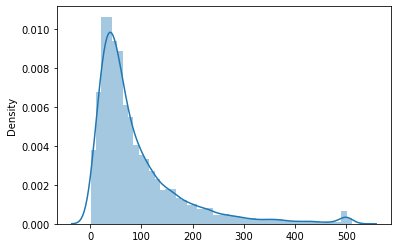

In [10]:
doc_lengths = []

for bio in bios:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [13]:
# the max token length   
len(doc_lengths[doc_lengths >100])/len(doc_lengths)

0.2939

In [14]:
np.average(doc_lengths)


91.22445

Load GPT2 tokenizer

In [15]:

# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [16]:

print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [17]:
batch_size =8


In [18]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=80):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:
      

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")
      # print(encodings_dict)

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [19]:
dataset = GPT2Dataset(bios, tokenizer, max_length=80)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

18,000 training samples
2,000 validation samples


In [20]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

Load pretain GPT2 model

In [21]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)


# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Setting parameters

In [22]:
# some parameters I cooked up that work reasonably well

epochs = 4
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [23]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [25]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [26]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):
  
    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,250. Loss: 3.1867334842681885.   Elapsed: 0:00:23.
0:  bipartisanhi here you are so happy to call your daughter for her first time since she gave birth


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,250. Loss: 2.772756576538086.   Elapsed: 0:00:44.
0:  increasinga question that many of our patients answer is it is possible that they had irregular menstrual periods that lasted longer than they actually did because the reason is that they never menstruated is not due to any hormonal deficiency or abnormal hormone production of the hormones that are stored within the blood cells like hb and estrogen or mn and do not increase estrogen levels while the cycle is active or it persists it is possible that the hormone that is stored in your blood is not going to be released when you go to see a gynecologist as it would be if the hormonal deficiencies in the brain were not in the blood cells do not necessarily persist as long as the stress is present in the body it is possible that you may also not have any other problems with the hormone that is stored in your blood cells


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,250. Loss: 3.1905665397644043.   Elapsed: 0:01:08.
0: dayhi i agree with your story the main point of this tale is that one of the female nurses at the hospital was a good patient but the fact that she was able to nurse for longer periods than her body was not enough for her to continue with her nursing career the nurse who was having her go at this time was being treated for anxiety and that is why he got sick so soon


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,250. Loss: 2.9244489669799805.   Elapsed: 0:01:29.
0:  Hangthis could be from the hormone levels that affect sex it is from a very very simple hormone imbalance that could have gotten in you i just want to point out that the weight loss that you have been told by your doctor is probably a result of hormonal imbalance the hormone imbalance is what causes your weight loss


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,250. Loss: 2.403006076812744.   Elapsed: 0:01:50.
0:  foodsa skin care provider must consider using a topical anti pimple cream with topical creams


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,250. Loss: 2.8147833347320557.   Elapsed: 0:02:11.
0:  trailhi and now i will tell you why you need to avoid this if you are going to be taken any medicines like this do not put you on them anything that can increase the dose of medicines you use for weight loss but if you are getting sick from the flu if you have high fever  which is good for you i recommend you to not eat any food


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,250. Loss: 2.988309144973755.   Elapsed: 0:02:32.
0: intendyes they do not have it all right you can see the medical history of someone taking a drug like hashimoto thyroiditis they would not be able to accurately estimate the amount of pain she or someone else is experiencing and you should do more research to get any specific information you could have been taking and get an stdgum test done


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,250. Loss: 2.874683141708374.   Elapsed: 0:02:53.
0:  surroundit depends how much you buy and where you live you will most likely choose a health insurance plan that offers people with pre existing conditions coverage that covers people who have a high risk child and children with special needs such as children under age six with a chronic disease like asthma or people with certain other conditions including people with low immunity who cannot take antibiotics because of influenza or certain other conditions health insurance plans include coverage that does not include high cost items such as vitamins or minerals coverage that covers people with chronic illness or people who have high blood pressure or who are prone to become dehydrated or overweight


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,250. Loss: 2.9658045768737793.   Elapsed: 0:03:15.
0:  reflexit is true that if you think about it it is just a coincidence that it happened to a pregnant women or a female partner this is very unusual especially in the case of the pregnant wife she does not want to give birth in fact and she wants to be safe for herself and her newborn she also has the option of having a spermicide they would be wise to get one at the pharmacy they are not too expensive but that would not necessarily mean you are the safest sex partner because it is important to get a complete pregnancy test at the time of conception good luck


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,250. Loss: 2.805119514465332.   Elapsed: 0:03:36.
0:  displayi would be hard to think of any type of medical situation where a person could have a heart attack without having a cardiac arrhythmia or high blood pressure but i have seen people who have had heart bypass surgery they tend to be having problems with their bcs because of their diabetes there are some serious complications if he is not going to be able to pay a reasonable fee for one he may be more susceptible if his medical provider has an open enrollment period and a policy based on an individual health plan i personally believe that if he is going to go to medical school he will have a good chance to have an impact on his health if he is a good student or doctor it is okay to get on to his doctor for counseling and getting a second opinion


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,250. Loss: 2.3595545291900635.   Elapsed: 0:03:58.
0:  pastorhi i guess no its not the h1c h1c does not seem to help this is actually the cause of h1c h1c does not seem to work


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,250. Loss: 3.0840814113616943.   Elapsed: 0:04:19.
0:  illicithi if your bleeding i recommend taking a blood test to rule out any underlying medical reasons and getting tested by your doctor its not a wise decision that would be difficult for you to get another chance of pregnancy if you have the money you will still want to get your money back from your doctors and other doctors can pay for a good doctor of yours as a condition that you must overcome it would be impossible to be sure if he has the right medicine for you but in my opinion he must be in medical school good luck


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,250. Loss: 3.5242700576782227.   Elapsed: 0:04:41.
0:  Liberationmany factors play a role in getting pregnant this time in a female person the mother is immune system has to work with her immunity and her body has to fight the immune system while the father is immune system is able to fight the immune system of the maternal blood fetus most people will need to get pregnant this time by age 35 of your body is immune system which is at work not just to fight the immune system in the presence of a cold virus it is also designed for that age a cold virus has the ability to send messages into the body from your skin to your eyes and body you could also get pregnant using an influenza vaccine but this is not going to help your cause so you will need to be carefully diagnosed and diagnosed as soon as possible after first you need to know your age and where it can be detected i guess so you will need to see a medical provider to confirm in any way if there is a cold virus 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,250. Loss: 3.1597323417663574.   Elapsed: 0:05:04.
0:  Namhi its just due to an allergic reaction do try using a cold bath will help good luck


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,250. Loss: 2.487609386444092.   Elapsed: 0:05:25.
0: IONi am sorry to hear this you are going through a loss of health and the pain you are facing can be very difficult for patients to cope with although the pain may be severe it is not that hard to deal with if you are under the constant stress of working and caring in the future you will need to be patient with your treatment and try to help yourself with all of that you need to make sure you are on a medication that is compatible with the kind of pain and ease of life that the doctor would be comfortable with


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,250. Loss: 2.851529598236084.   Elapsed: 0:05:47.
0:  glimpseno you will not lose anything you are safe but you will need more of a health care professional like this or someone that knows you


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,250. Loss: 2.7268283367156982.   Elapsed: 0:06:10.
0:  Laurethis could be something very serious… it is possible you have a chronic pain from a heavy blow if this is a very serious situation you need to be investigated and treated


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,250. Loss: 2.7964859008789062.   Elapsed: 0:06:32.
0: ismyour body needs to be fighting off infection for the rest of its life and not trying to keep the immune system running at this time so as you are experiencing complications of your infection i suggest you go to the hospital to have a ct scan to be properly diagnosed and treated


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,250. Loss: 2.4803237915039062.   Elapsed: 0:06:54.
0: ounwell it seems to have to with her having a tubal hernia there is no need for an mri after the surgery but i would like to give her a mri and a complete ultrasound done and her doctor will be happy that its on its proper antibiotics


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,250. Loss: 3.2394423484802246.   Elapsed: 0:07:15.
0:  electionhi its time to see your doctor asap so you can be properly diagnosed and properly treated


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,250. Loss: 2.4959945678710938.   Elapsed: 0:07:35.
0:  crazyhi so on that link its just a good one just copy link into google to the www to open and read its from www pegym com its down to what you really want good luck


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  2,250. Loss: 2.3625948429107666.   Elapsed: 0:07:56.
0:  benchyes it is possible for one person to develop tuberculosis or for the next person to develop tuberculosis other than being susceptible to tuberculosis   most people with tuberculosis have some type of infection that can contribute to other symptoms of tuberculosis you will be wise to use the care you need    whether it be taking proper medicine or medications    to prevent or delay treatment as it can be hard to do everything right

  Average training loss: 3.09
  Training epoch took: 0:08:07

Running Validation...
  Validation Loss: 2.55
  Validation took: 0:00:14

======== Epoch 2 / 4 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,250. Loss: 2.8747382164001465.   Elapsed: 0:00:20.
0:  incorporatedthe cause of infertility in some women can be treated with lifestyle changes and lifestyle modifications in others infertility can be surgically diagnosed and treated by surgery but most infertility treatments are a long term solution one of the best treatments for infertility in women is fertility therapy it is also a very popular form of treatment for infertility in men    especially those with epilepsy   is fertility treatment the treatment is not as important as its treatment in some cases fertility therapy is treated at the very least with a combination of medications and the treatment is generally considered to be permanent and the treatment usually lasts longer than that the most infertility treatments have been associated with infertility problems for people with epilepsy the key to fertility therapy is to make sure that the hormone replacement therapy is the right hormone estrogen in additi

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,250. Loss: 2.604436159133911.   Elapsed: 0:00:43.
0: Peteri have no way of confirming or disputing your diagnosis blindly over the internet based solely on your vague description your description is very vague you would need to see an stdgum clinic for an examination and possibly to have it checked out the other possibility that may be present is a yeast infection there is a reason why yeast infections are so common in children especially if it is not on your genital area you can consider taking the same medicine as you had and getting on the same antibiotic as well to make sure everything is ok


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,250. Loss: 2.3303685188293457.   Elapsed: 0:01:04.
0: uringhi yes there is a possibility you could still be pregnant if you didnt get on bc before you have your period the best thing you can do would be try for it to happen hope this helps you good luck


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,250. Loss: 2.7785019874572754.   Elapsed: 0:01:25.
0:  reproductivewell it seems that this is a cyst or not… do you know of any other type of pain in body do you know of any new symptoms for you if not you should go to your doctor to find out… it may be due to your body having a good olith…


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,250. Loss: 2.46464204788208.   Elapsed: 0:01:46.
0:  zonehi a ringworm is in your early stages of development a few months late but if you have been on antigens for over a month or are not feeling any signs of this just try to get a consultation with your doctor if you think you are having an emergency it would be wise to get a second opinion from a gastroenterologist this will be a test that can confirm or deny a diagnosis


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,250. Loss: 2.2670865058898926.   Elapsed: 0:02:08.
0:  commitsyes


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,250. Loss: 2.6490070819854736.   Elapsed: 0:02:28.
0:  ironyit is always possible to get pregnant when a woman has a retained or fertilized egg for more than 3 days and the ovulation bleeding is not completely gone it is still possible for an egg to fertilize a fertilized egg that is just a temporary temporary loss of the ovulate however


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,250. Loss: 2.1509547233581543.   Elapsed: 0:02:49.
0:  Sahhi the most probable location that causes pinning of the vertebra is on the right side and the laminectomy is the other possibility i advise you to get a ct scan done and get a ct angiogram done on the laminectomy in case if its pain


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,250. Loss: 2.405055522918701.   Elapsed: 0:03:10.
0:  Bryanthere is a great deal of research that shows that acupuncture is an effective treatment of type 1 diabetes that actually lowers blood sugar levels and makes it difficult to prevent type 1 diabetes it is also seen in some people with type 1 diabetes and in patients with a history of other conditions or conditions in which the blood sugar levels are elevated many times the type 1 diabetes itself can be cured by treatment with an endocrinological system of sorts some type this means treatment works only after treatment with the underlying disease with certain medicines and medications but some may actually reduce the sugar levels in those cases acupuncture may also reduce insulin levels as treatment works by treating acute diabetes and is usually a treatment not required to prevent the disease without the proper care doctors and treatment facilities are typically used to treat diabetes in the u s many cases pe

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,250. Loss: 2.724299669265747.   Elapsed: 0:03:33.
0:  spiritsyou need to make a appointment with your physician so you can be properly examined there are no significant interactions to be concerned about with this medication


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,250. Loss: 1.5684348344802856.   Elapsed: 0:03:53.
0:  seesthat would depend on the severity of the pain of the laceration and on your blood pressure if you take aspirin or any other medication this is not considered a separate medical problem and your medication must be specifically prescribed for your medical condition


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,250. Loss: 2.7333316802978516.   Elapsed: 0:04:14.
0:  hungryhi this can be a side effect of you and your find its a real thing and should go away a couple of years before the real thing gets back to normal for you then take this med with lots of help and get to a good start if things do not help keep away from other ways things have to work with your doctor if things do not help then you need to do this meditation google this med and see how the med works and it may help you manage your anxiety better just get to a good start the med does not work for you just mix and match all mix is all the way good luck


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,250. Loss: 2.8536317348480225.   Elapsed: 0:04:36.
0:  PThi i recommend checking out your body is own vitamin d levels for sure thanks


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,250. Loss: 3.010247230529785.   Elapsed: 0:04:57.
0: üthe most common cause of eye discharge is called conjunctivitis conjunctiva sinusitis which is an inflammation of the face over a period of several days conjunctivitis usually lasts for five to seven days and is usually caused by inflammation of the conjunctiva sinuses usually are affected by irritation of the eyes it is important that you do not use or delay any eye care measure that might trigger conjunctivitis you should talk to your doctor and get evaluated in light of possible allergic reaction to eye drops or other prescription medications medications you may also have to take oral medications you are allergic to topical or topical irritable medications like ibuprofen aspirin naproxen ibuprofen is the brand name ibuprofen is a steroid that causes the burning pain that can affect conjunctiva sinuses and causes irritation of the eye also irritable bowel


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,250. Loss: 2.1974563598632812.   Elapsed: 0:05:19.
0: rucethe type of blood pressure medication that is used for treating constipation are based on the specific symptoms of the constipation that are related to the type and duration of symptoms the reason that this medication is prescribed for constipation is because the symptoms appear to be caused by a specific pattern of symptoms some people and patients use constipation at the same time or at the same time each day since the blood pressure medication is not a diary for one specific person or two or two to determine when the symptoms appear you need to take two separate doses of the blood pressure medication to ensure that the person is level of the medication at that time i would not recommend that you start with two separate dosages in the first 12 hours of a period you take it once a day to confirm that you have no signs of constipation


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,250. Loss: 2.36043643951416.   Elapsed: 0:05:41.
0:  derivativesyes the new law does indeed change the way that medications are made


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,250. Loss: 2.110405683517456.   Elapsed: 0:06:02.
0: hi yes you can start a new period now but first of all a bit of a worry you can still wait until you get pregnant until you have started then you can wait till you miss your next period if your next period is within two weeks good luck


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,250. Loss: 2.081698179244995.   Elapsed: 0:06:23.
0:  rememberingi am not a doctor or primary care provider but rather a licensed health care professional if your child is self care practitioner i assume your child is not performing such routine physical exams that can be challenging and expensive for them to determine how much stress that stress is on to the health care professional should be able to determine if she is doing a great job for you or not


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,250. Loss: 2.1204586029052734.   Elapsed: 0:06:44.
0:  Sourceshi sorry but no we both can understand that you are asking your question at the same time and one of those things i do not think can be changed at this time of the year the only thing that can be changed is that your periods are normal for a time now i would get to your doctor and see what heshe says to try and change your period it could be up to 2 days before and 3 days afterwards this could cause a problem like you now but we need to get over it and see if it can be solved good luck


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,250. Loss: 2.4493772983551025.   Elapsed: 0:07:06.
0: emsanyone with the usual risk of developing parkinson is disease has also seen progressive deterioration of symptoms in men with this disease it is important to follow all treatments as appropriate and be sure that you are getting all the essential vitamins and nutrients from each diet plan as for those nutrients you can start eating fruits and vegetables and whole grains these will all reduce your risk of having parkinson is


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,250. Loss: 2.7891595363616943.   Elapsed: 0:07:27.
0: tzyou can definitely use zyrtec and kyphotic in your area without adverse effects if you are allergic to the shingles virus you will not get the shingles shingles and shingles are both childhood children and can cause different problems and affect people equally i would recommend visiting your pediatrician for further information on this condition in addition to treating shingles keep an eye on your shingles diagnosis for two weeks after you return for more information we will also be able to make sure you are getting the information in general if you return in our new information section zyrtec is used to treat shingles symptoms and other diseases


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  2,250. Loss: 2.552093744277954.   Elapsed: 0:07:49.
0: matichi its possible from this to lead to miscarriage or even the menopause its best you to wait till after a miscarriage for a test then just wait it will come but there wont be any way for me get a test done there should be a way you can not miss as it may go through the abortion process its not as if its all that you need as this may also happen in case of spotting i suggest doing another test

  Average training loss: 2.41
  Training epoch took: 0:08:00

Running Validation...
  Validation Loss: 2.50
  Validation took: 0:00:14

======== Epoch 3 / 4 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,250. Loss: 1.8069177865982056.   Elapsed: 0:00:20.
0:  syndthere is no evidence to suggest that this would be the case in women who have not had a period and therefore have irregular periods there may be a problem with the way this hormone is tested if it is a normal amount and if it is on your own or if you are using birth control pills and if you have a pregnancy test for any reason it is always a good idea to discuss this with your medical provider it is best to get the correct dosage at the end of the day


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,250. Loss: 2.386199474334717.   Elapsed: 0:00:42.
0:  gamhi if this is just a hic cup then the doctor should be ok for you its a virus that can leave you feeling just like this could be from the time you was on it before but that would be the only thing that can give you the same thing hope this helps good luck


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,250. Loss: 2.3198299407958984.   Elapsed: 0:01:03.
0:  injuryin my opinion no the bleeding is not caused by a cardiac event there are no chances of heart related cardiac related issues


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,250. Loss: 2.4166672229766846.   Elapsed: 0:01:24.
0: azayes the flu vaccine contains an important active ingredient and the fda is monitoring the development of a vaccine that protects against both influenza and chicken pox in the future


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,250. Loss: 1.7763099670410156.   Elapsed: 0:01:44.
0:  membranehi yes this can be treated better by physiotherapy laser ultra sound therapy and laser treatments on the joint tissue with anti inflammatory medications consult a orthopedist thanks


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,250. Loss: 1.9872779846191406.   Elapsed: 0:02:05.
0: ijingit seems that you have an enlarged lymph node you need to confirm it with a nephrologist and get a recent xray to confirm also do a lymph node biopsy to confirm it can be a fungal infection


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,250. Loss: 2.2837142944335938.   Elapsed: 0:02:26.
0:  castyes you should take them two tablets at once


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,250. Loss: 1.3713111877441406.   Elapsed: 0:02:46.
0:  purchyes there is some information in that the american cancer society recommends you take when you have a gallbladder prolapse gallstones are found in the gallbladder gland and gallstones in the uterus the gallbladder function helps the body break down cholesterol and the intestine which trap and destroy cholesterol gallstones also are found in the abdomen and belly the gallbladder causes gallbladder prolapse and can damage the bladder kidney bladder and pelvic organs gallstones can also occur in the legs or the back of a limb and in any part of the body the gallbladder is located in the lower leg and external shoulder area gallstones also occur in the stomach and in the groin area prolapse can occur at any part of the small intestine or a small intestine or abdominal region of the abdomen or in the pelvis and groin groin but occur most people have no symptoms gallbladder


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,250. Loss: 1.9067569971084595.   Elapsed: 0:03:09.
0:  shouldersi am afraid i can not blindly make a blanket statement as to the reason your doctor has prescribed this antibiotic i have had four previous cases of bacterial vaginosis and i have always had a strong negative patient relationship with the antibiotic i cannot really answer that question because i am not a medical professional i do not have to do it but i do want to tell you that you have to be careful with this antibiotic and you do not want to over give it to your boyfriend this condition in general it is perfectly ok to use an antibiotic on your own personal medications so i do not want to just give you the benadryl i would not to give you a bad night sweats because i am not even assuming his cough has something to do with it so since i do not know his medical history since this is a chronic bronchitis i would not recommend giving it to someone who has had this condition at least you as a primary care

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,250. Loss: 1.8994585275650024.   Elapsed: 0:03:31.
0:  builtyou will need to see a doctor or a doctor is office for the specific reason for your skin eruption and your medical history


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,250. Loss: 1.9448182582855225.   Elapsed: 0:03:52.
0:  openlyhi it seems the shingles shots are of no help if you have a mobile phone its better that you have an ivy ring instead of having an ivy shot look first as ivy shots can give you problems over a long term if you have had a mobile phone it would help as it will give you more problems if you have a mobile phone it would be better for you to have a mobile phone see if they can give you an ivy shot but it would be of no help if its been mobile it would give a mobile problem at a time when there really are no mobile problems but its not your problem it would be best to have a mobile problem or just get a mobile problem it could be got on your finger and never use the ring it would put in the way of getting through ivy your body as ivy and get you will never get that done then as you get an ivy shot good luck


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,250. Loss: 2.2608606815338135.   Elapsed: 0:04:14.
0:  haltedthere really is a limited number of medications that can be used for schizophrenia according to the american academy of pediatrics a medication list currently exists for schizophrenia treatment includes anti depression medications such as nyquil zegerine benadryl diphenhydramine pseudoephedrine pseudoephedrine phenobarbital and lexapro valium as well as medications for schizophrenia in the american academy of pediatrics if that is what they are intended for you cannot really expect to suddenly become depressed without antidepressants we would need to ask the patient why they are taking them lexapro or lexapro and if they believe they are depressed without lexapro


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,250. Loss: 2.2031946182250977.   Elapsed: 0:04:36.
0:  Nikhi here is some very interesting looking webmd answers on penis health <link> this piece discusses erectile dysfunction symptoms in men and boys men suffer from erectile dysfunction in most cases it is not caused by something the person is doing or is doing against their will erectile dysfunction also can be a condition seen in the general population men who are deficient in iron and vitamin d can develop erectile dysfunction these are the main causes of erectile dysfunction depression is associated with poor self esteem and men who smoke  poor diet and no exercise poor diet and poor exercise and men who smoke exercise are more likely to suffer erectile dysfunction  erectile dysfunction can also be a disease in children and teenagers and adults with juvenile onset of juvenile onset of juvenile onset of erectile dysfunction when you can occur in both boys age groups boys in general men and men and young men w

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,250. Loss: 1.3870073556900024.   Elapsed: 0:04:58.
0:  tinthat is a good question you ask the pharmacist we recommend that you check the package label and make sure that there is no drug that is going into your system that is how we tell you to go do it a lot of medications have to be in the brand so the brand name may have something that is not in it so you might have to change a medication and it will not have to be in the same product we also tell parents and they can take the medication from the pharmacist who can help find the best products to take and give it to their child so in the pediatric world sometimes you can have to call your pediatrician and tell them the okay to take the product and make sure they are allergic or pick up some of the medication that comes in the pharmacy or call a pharmacy that is just different brand and brand names that may be available and sometimes it can be in some of the lot of different formulations they can be in the package

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,250. Loss: 2.089061975479126.   Elapsed: 0:05:21.
0:  clinicalthis is called an early secondary bacterial infection assuming the organism did not have viable sputum bacteria in it is most contagious within 24 48 hours of exposure to the bacteria it can infect the skin and bloodstream in about 7 of cases bacterial infection is suspected bacterial culture results are done after an initial culture with high resolution microscopic analysis of the organism has been done the incubation time from exposure to the bacteria to the infection varies with the organism so the organism may not have survived long enough to be contagious so if it is still contagious and not active after a proper treatment it is not contagious to be patient you may be contagious to keep it to a doctor is office for 2 or send the patient to another room for observation it may be exposed to another patient for another week or 2 or 3 weeks until antibiotics are completed


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,250. Loss: 2.1697514057159424.   Elapsed: 0:05:44.
0: lectionshi this could be hormonal imbalance with underlying stress get hbg test done and get the mri done consult a gynecologist thanks


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,250. Loss: 2.02813982963562.   Elapsed: 0:06:04.
0: elshi i think your find it should go away as its a bit long for a period to go on it do hope this helps you good luck


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,250. Loss: 2.555711030960083.   Elapsed: 0:06:25.
0: labif it is an outbreak     it is a good indicator of infection in future cases in some cases a blood clot    called a hard clot   is infected the fluid has moved from the wound to the surface causing a pocket of blood clotting fluid filled with pus and pus on the wound that is oozing pus can move to other areas of the body so that they could eventually retreat back to their infected places if this is the case a pocket of blood clot will become infected


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,250. Loss: 1.9871623516082764.   Elapsed: 0:06:46.
0:  triplehi the blood seems to have passed this far its most likely that he has an enlarged lymph node he should consult a physician immediately good luck


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,250. Loss: 1.4153485298156738.   Elapsed: 0:07:07.
0: 220there is nothing over the counter that is as effective as what you are using there are lots of over the counter pain relievers that are for the worse but for most people i think you should ask your ob since you are over the age of 21 or in the early 60 is this an age group that would really benefit you and your family what you have in mind is that pain in the morning is probably associated with some chronic constipation    or chronic diarrhea that is associated with chronic inflammation or infection so perhaps that is what would be your concern here is your diet may be causing the burning it is really can be best to see a diet and possibly see a good doctor and go to the er and ask you may want to have a proper amount of hydration that is really need to see a doctor


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,250. Loss: 1.7655123472213745.   Elapsed: 0:07:29.
0:  Seehi i cant see what your doing with your penis getting erect during masturbation it is a mystery to me as you may find it to be an erection but please read this link <link> just copy this link into google to open and read if it does not work do not go see your doctor asap just take it from there you may need to get on some kind of meds or have some kind of an std test it would be best to see that guy to see what is going on


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  2,250. Loss: 2.1809964179992676.   Elapsed: 0:07:51.
0: @@i believe so they would both be fine as long as you both have a valid valid medical justification

  Average training loss: 2.09
  Training epoch took: 0:08:01

Running Validation...
  Validation Loss: 2.50
  Validation took: 0:00:14

======== Epoch 4 / 4 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,250. Loss: 1.521431803703308.   Elapsed: 0:00:20.
0:  hosthi i think its a good thing but when the dose gets higher your having nausea for longer periods than usual and yes you should see a doctor if it has not helped then get to your er asap good luck


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,250. Loss: 1.7441400289535522.   Elapsed: 0:00:41.
0: roleif you are not allergic to any food or medicine you are allergic to wheat gluten these foods and their ingredients are the same as those used in food poisoning but they are not identical you can find information about various foods that can cause gastrointestinal symptoms in people who have allergies by calling the dietitian if you can get an idea of what you might be allergic to talk to your health care provider


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,250. Loss: 1.9313087463378906.   Elapsed: 0:01:03.
0: iachi have a good read through this link its from the uk is nhs lots of info that is very helpful even for us who live in the us its from the uk is nhs its all free you can do to get help good luck


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,250. Loss: 1.5775682926177979.   Elapsed: 0:01:23.
0:  LDhave fun i will get you an answer


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,250. Loss: 1.3620761632919312.   Elapsed: 0:01:44.
0:  Listeni do not believe that i have seen it but i do not think that a zygote is a parasite


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,250. Loss: 1.994710087776184.   Elapsed: 0:02:04.
0:  dyyes you could actually be pregnant


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,250. Loss: 1.631001353263855.   Elapsed: 0:02:25.
0:  Domesticit sounds like you should get this checked out by your primary care doctor because the cause of your symptoms could be a virus or a bacterial infection at the very least you may need an antibiotic if this does not clear up within a couple of days you may need to have your medical provider order another test to look for other causes of your symptoms


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,250. Loss: 1.7542253732681274.   Elapsed: 0:02:46.
0:  beneficiarieshi if all his tests are normal then it could be just a skipped period if no symptoms or pregnancy that is if this is the last test he had done then you should take him to a doctor to get test results done if not then they can be advised a blood test can be taken if its negative that can help get a usg abdomen done thanks


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,250. Loss: 1.538340449333191.   Elapsed: 0:03:07.
0:  Titlehi if a child has diarrhoea a fever doesnt seem to be dangerous it is better to get an ebola shot to check for the infection take antimalarial medicines and get a complete usg of abdomen done hope this helps


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,250. Loss: 1.7409687042236328.   Elapsed: 0:03:28.
0:  μyes many times in a half hour or two of hot water not enough to see her urine the red part of the urine will turn green and the green part of the urine will become cloudy depending on the amount of urine that is being analyzed if she has two small children in one room she could be getting plenty of urine and there are other reasons for this


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,250. Loss: 1.5732725858688354.   Elapsed: 0:03:49.
0:  sellingthere are several reasons for acne breakouts common reasons include your acne may have changed over time and hormones may have thrown it off balance hormonal fluctuations could cause more breakouts to occur hormonal imbalance may also increase the turnover rate of your skin so it may be better to try a natural skin care regimen that is dermatologically tested prior to applying your acne because you have not had it in a while there may be a time limit to your hormones for women who do have severe acne acne breakouts or if you do have a severe acne you could be treated by a prescription ointment containing pepto oil to help it settle down and work its effectiveness it is best to consult a good dermatologist


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,250. Loss: 1.9394222497940063.   Elapsed: 0:04:11.
0:  migrantyes you can get a flu shot at any time influenza virus can stay on your body for a short period of time even if your symptoms are mild you still can still get the shot


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,250. Loss: 1.1648505926132202.   Elapsed: 0:04:32.
0: ivelyno there is no evidence to suggest the disease would progress to cervical cancer again there is little or nothing clinical evidence that acupuncture will have any therapeutic benefit


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,250. Loss: 1.8446661233901978.   Elapsed: 0:04:53.
0:  ordera pregnancy test for chlamydia is considered safe in pregnancy if your medical provider or ob gyn did not specifically ask you to repeat a test for chlamydia he or she would have recommended that you do so do not be prematurely concerned


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,250. Loss: 2.127811908721924.   Elapsed: 0:05:14.
0:  VPNmost helpful answer it is not likely you were exposed to any type of herpes by the penis of a female you will always have a sore throat sore like yours the only thing you can do is wait for the herpes to go away without leaving a scar that you will never have again if you have not had a sore throat for over 2 weeks or so you have spread the virus to your groin area area the location where you developed the sore throat was obviously not the location of your initial outbreak


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,250. Loss: 1.950222134590149.   Elapsed: 0:05:35.
0:  explanationas much as i would like to address your concern i cannot the cause of your daughter is constipation is it is not true constipation is just some fluid that her body must process every day or so you may feel some burning sensation in her lower back and lower abdomen as the constipation becomes more frequent she may experience a mild gastric upset nausea vomiting and burping this can occur in people of all ages as long as the constipation is occurring in children for the most part she is fine it can cause other symptoms including cramping and a fever these symptoms may also occur in older children over the age of 1 and 2 having light sensitivity to light the food she may experience nausea vomiting for a short time or having difficulty breathing although the vomiting does not disappear for 2 diarrhea or diarrhea can be a sign of serious it can continue for a long time


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,250. Loss: 1.3473870754241943.   Elapsed: 0:05:58.
0:  Bachthe cause of bipolar disorder is unknown but a number of factors may play a role this includes an individual is age stress abuse past traumas such as a child abuse suicide attempts disorders that result in an individual making too much money or a high risk for medical problems such as strokes heart disease or strokes bipolar disorder increases the risk of serious health consequences such as stroke heart failure or major depression for men of this age and may be present in a more severe form for people over 35 years of age stress may lead to severe or long term problems with mood disorders people whose risk for serious health problems increases while they are at an early stage of depression may experience a panic attack before symptoms flare up they may experience a mania or mania panic disorder with depression during the manic episodes a mania is a mania may occur during one episode of depression a mania ma

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,250. Loss: 1.9591331481933594.   Elapsed: 0:06:21.
0:  folderas you probably know i do not know anything about you or your condition to suggest a specific exercise plan but here is a couple of suggestions your first step is to get out and get into the exercise program eat a healthy diet eat well balanced meals with plenty of fruits vegetables and whole grains eat a healthy diet when you eat well balanced meals the first quarter of your meals should be about 100 calories less saturated fat than saturated proteins and fat if you are having issues with cholesterol or high blood cholesterol your blood pressure needs to be checked out by a doctor while a cholesterol level of less than 200 or above is considered borderline high remember that regular exercise can result in lower blood pressure as well as heart disease so do not just try to maximize your workouts the weight you are building blocks and make it easier for you to exercise do not starve them if you want to get

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,250. Loss: 1.8719565868377686.   Elapsed: 0:06:43.
0:  buildingthe law requires insurers to cover the cost of services provided to people who buy insurance on their own or work based health plan if you buy a policy on your own you will not be eligible for tax credits nor will it count toward your annual income


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,250. Loss: 1.2744133472442627.   Elapsed: 0:07:04.
0:  Babylonbreathing problems are common after prostate surgery surgery the prostate sits just below the bladder the lower abdomen the neck and back the lower limbs the lower abdomen and the upper respiratory tract also tend to sag down at the low back this sometimes referred to as a saggy belly  the prostate sits just behind the bladder and so does the rest of the body the neck and lower limbs produce a lot of fluid in this area and sometimes it causes pain and pressure in this area it can even be called the lower abdomen or the groin so in a person who is having pressure symptoms of having a saggy belly often the doctor may remove the bladder and put the area of the surgery in contrast with a cool mist humidifier with a stream of urine this usually referred to as a sphincter a deep state the fluid drain the doctor may put a barium swallow the barium or the doctor may put some salt water straight into a small bag 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,250. Loss: 1.7560343742370605.   Elapsed: 0:07:27.
0: periali would suggest you contact your local state health insurance assistance programs for free unbiased help selecting a plan go to healthcare gov


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  2,250. Loss: 1.6811639070510864.   Elapsed: 0:07:47.
0:  rentshi there seems to be internal hemorrage around you ear may be blocked or wax impaction in your ear drum may also cause it get examined for confirmation and anti ear wax as it may have drained out completely consult an ent specialist thanks

  Average training loss: 1.74
  Training epoch took: 0:07:58

Running Validation...
  Validation Loss: 2.58
  Validation took: 0:00:14

Training complete!
Total training took 0:33:01 (h:mm:ss)


In [29]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,3.09,2.55,0:08:07,0:00:14
2,2.41,2.50,0:08:00,0:00:14
3,2.09,2.50,0:08:01,0:00:14
4,1.74,2.58,0:07:58,0:00:14


In [30]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/drive/MyDrive/2.model'

# Create output directory if needed
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Saving model to /content/drive/MyDrive/2.model


('/content/drive/MyDrive/2.model/tokenizer_config.json',
 '/content/drive/MyDrive/2.model/special_tokens_map.json',
 '/content/drive/MyDrive/2.model/vocab.json',
 '/content/drive/MyDrive/2.model/merges.txt',
 '/content/drive/MyDrive/2.model/added_tokens.json')

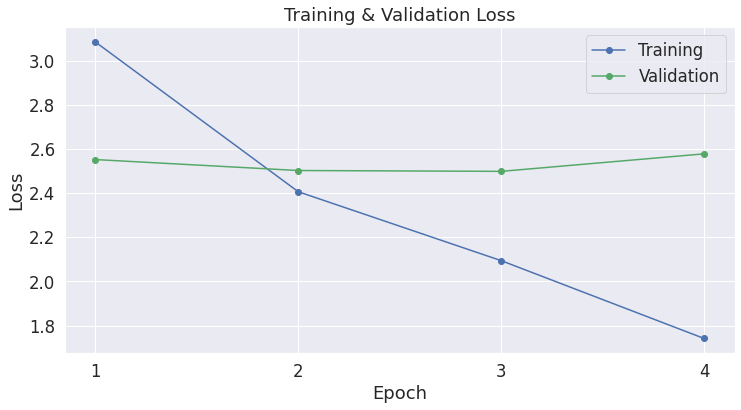

In [31]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

**Importing the saved model**

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 70.5 MB/s eta 0:00:00


In [3]:
import torch

In [4]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained('/content/drive/MyDrive/2.model')
model = GPT2LMHeadModel.from_pretrained('/content/drive/MyDrive/2.model')


In [48]:
model.eval()

prompt = "i am feeling pain in my front tooth"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
# generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 100,
                                top_p=0.95, 
                                num_return_sequences=1,
                                # temperature=1,
                                )

for i, sample_output in enumerate(sample_outputs):
  print(sample_output)
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
  result = "{} : {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True))

  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[   72,   716,  4203,  2356,   287,   616,  2166, 16162]])
tensor([   72,   716,  4203,  2356,   287,   616,  2166, 16162,  1312,   466,
          407,   892,   644,   345,   423,   318,  3487,   340,   743,   307,
          281, 10280,   393,  1223,  2073,   467,   284,   534, 38408,   340,
          318,   262,   691,   835,  1312,   460,   307,  1654,   290,   428,
          318,   644,   318,  6666,   534,  2356,  1312,  4313,   345,   651,
        10667,   290,   766,   534, 38408, 50256])
0: i am feeling pain in my front tooth i do not think what you have is normal it may be an infection or something else go to your dentist it is the only way i can be sure and this is what is causing your pain i recommend you get checked and see your dentist




Applying model evaluation metrics

In [ ]:
from nltk.metrics import *

In [76]:

input_ids = sample_output
print(sample_output)

# Calculate the perplexity of the generated text
loss = model(input_ids, labels=input_ids).loss
perplexity = torch.exp(loss)
print('Perplexity:', perplexity.item())


tensor([   72,   716,  4203,  2356,   287,   616,  2166, 16162,  1312,   466,
          407,   892,   644,   345,   423,   318,  3487,   340,   743,   307,
          281, 10280,   393,  1223,  2073,   467,   284,   534, 38408,   340,
          318,   262,   691,   835,  1312,   460,   307,  1654,   290,   428,
          318,   644,   318,  6666,   534,  2356,  1312,  4313,   345,   651,
        10667,   290,   766,   534, 38408, 50256])
Perplexity: 11.716421127319336
